# Setup Code

In [146]:
import torch.nn as nn
import torch.nn.functional as F 
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import itertools

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import layers
import solvers
import nets

from params import *
from config import *

import utils

%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

utils.print_info()

params = SPRITESParameters()
img_size = params.img_size
img_channel = params.img_channel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.4.0
using device: cuda
data type: torch.float32
VERBOSE== False


# Data Loading

In [134]:
dataloader = utils.dataLoader('SPRITES')

# Network Architecture

# Step1: train s encoder and classifier
the encoder+classifier structure has achieved 97% accuracy on MNIST

In [143]:
#test S encoder
nets.test_Encoder(nets.S_Encoder(params),params)
#test z encoder
nets.test_Encoder(nets.Z_Encoder(params),params)
#test s classifier
nets.test_classifier(nets.S_Classifier(params),params)
#test decoder
nets.test_Decoder(nets.SZ_Decoder(params),params)

torch.Size([64, 32])

torch.Size([64, 128])

torch.Size([64, 336])

torch.Size([64, 3, 32, 32])



332
59


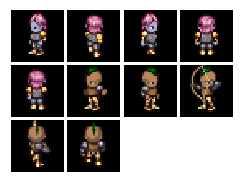

In [135]:
dataloader.show_imgs()

In [147]:
s_enc = nets.S_Encoder(params)
s_classifier = nets.S_Classifier(params)
classifier_solver = solvers.ClassifierSolver(s_enc, s_classifier, dataloader, params)

In [ ]:
classifier_solver.train(100)
classifier_solver.test(mode = 'test')

In [127]:
#new_s_enc = nets.S_Encoder(params)
utils.save_models(s_enc,mode='param',mode_param = '')
utils.load_models(s_enc,path=var_save_path,suffix='')

In [138]:
classifier_solver.test(mode = 'test')

Checking accuracy on test set
Got 4807 / 5000 correct (96.14)


0.9614

In [113]:
dataloader.imgs.shape

(1024, 3072)

torch.Size([8, 3, 60, 60])
tensor([ 134,  331,   82,  134,   47,  134,  331,  134], device='cuda:0')


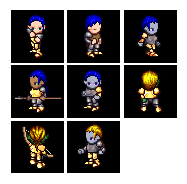

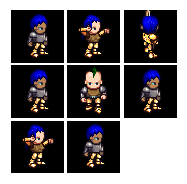

In [81]:
num=8
#ori_imgs=torch.stack(dataloader.img_grouped[200][0:num])
ori_imgs = torch.tensor(dataloader.imgs[0:num])
test_imgs = ori_imgs.view(num,img_channel,img_size,img_size)
print(test_imgs.shape)
predicted = classifier_solver.predict(test_imgs)
print(predicted)
clss = list(predicted.cpu().numpy())
utils.show_images(ori_imgs,params)
dataloader.show_imgs(clss,show_num=1)

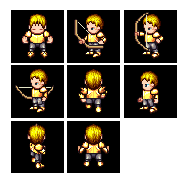

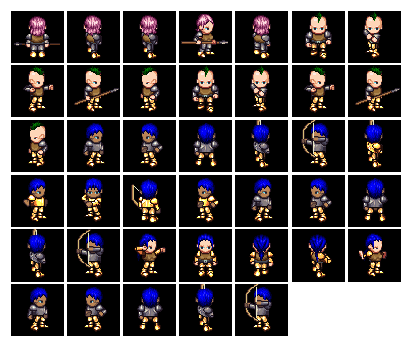

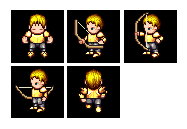

# Step two, train disentangle-adversariel network

In [129]:
def get_DisAdvSolver(loading=False,name = ''):
    if loading==False:
        z_enc = nets.Z_Encoder(params)
        z_adv = nets.Z_AdvLayer(params)
        sz_dec= nets.SZ_Decoder(params)
        s_encoder = s_enc
        solver = solvers.DisAdvSolver(s_encoder, z_enc, sz_dec, z_adv, dataloader, params)
    else:
        solver = solvers.DisAdvSolver(dloader=dataloader,params=params, loading=True,loadSuffix=name,model_name='trueTest',saving_while_training=True)
    return solver

In [130]:
solver = get_DisAdvSolver(loading=False, name = 'firstTry')

progress: 0.00, total iter: 5000, losses: recon:0.0126, disent:-3.0038, adv:6.0328 
z_latent_norm: tensor(38.1967, device='cuda:0')


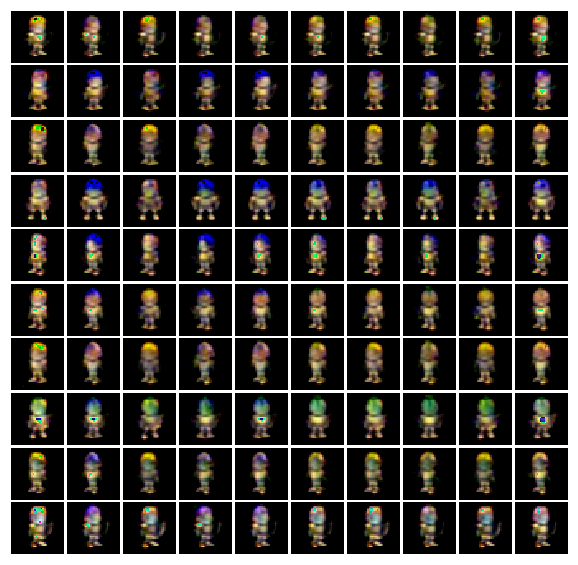

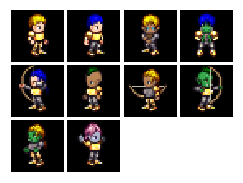

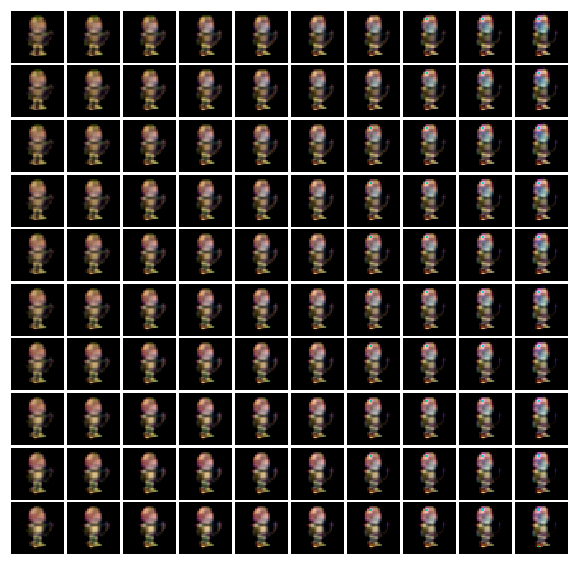

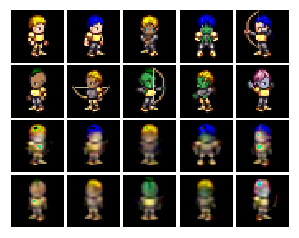


progress: 0.00, total iter: 6000, losses: recon:0.0120, disent:-2.9975, adv:6.0198 
z_latent_norm: tensor(43.1641, device='cuda:0')


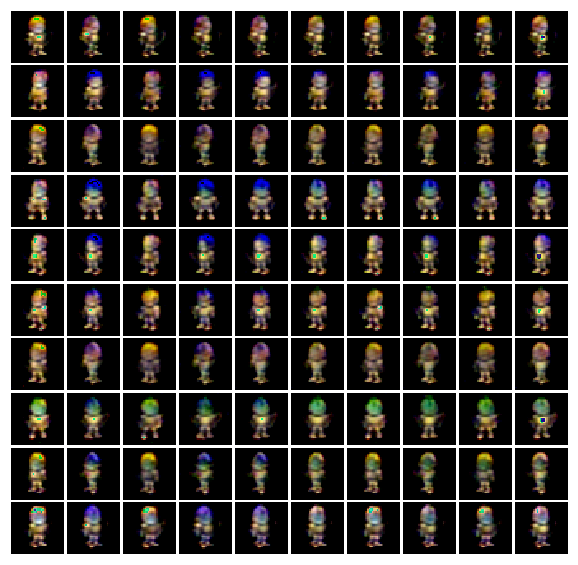

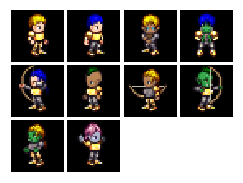

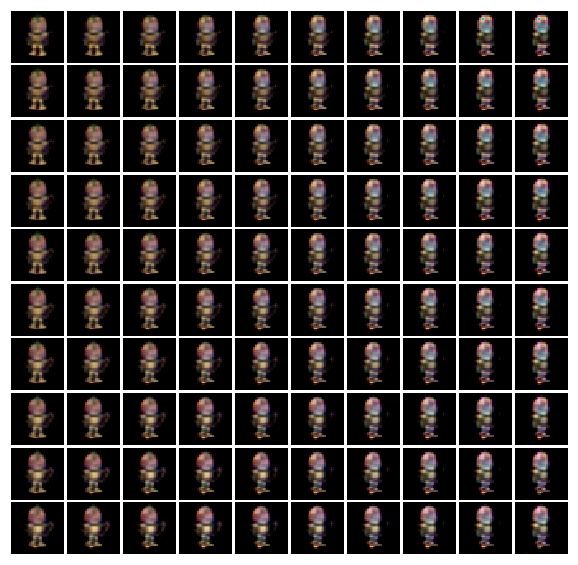

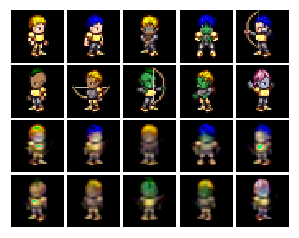


progress: 0.01, total iter: 7000, losses: recon:0.0116, disent:-2.9899, adv:6.0043 
z_latent_norm: tensor(47.8665, device='cuda:0')


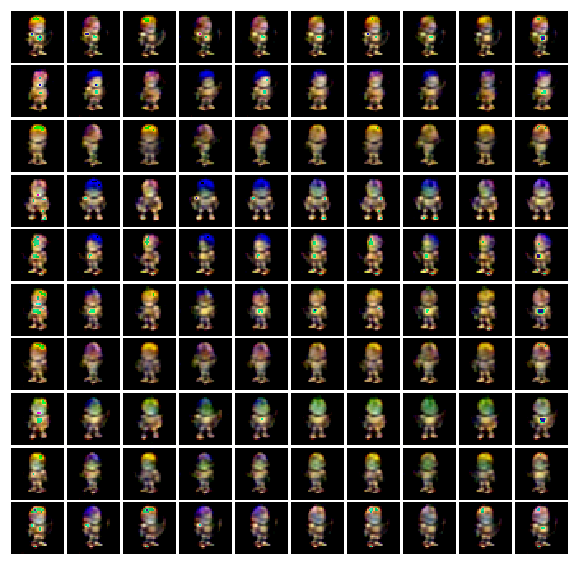

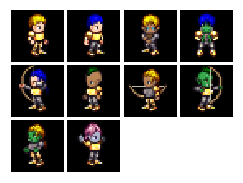

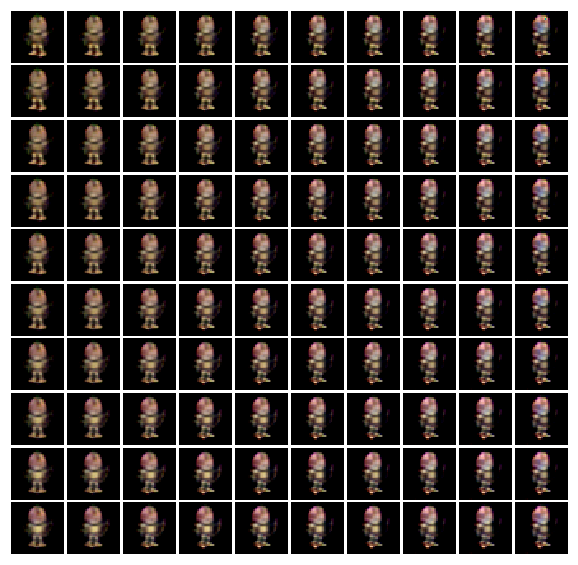

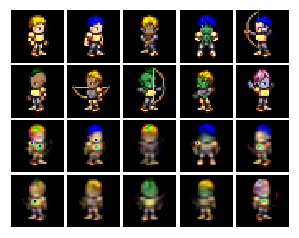


progress: 0.01, total iter: 8000, losses: recon:0.0111, disent:-2.9811, adv:5.9849 
z_latent_norm: tensor(51.2480, device='cuda:0')


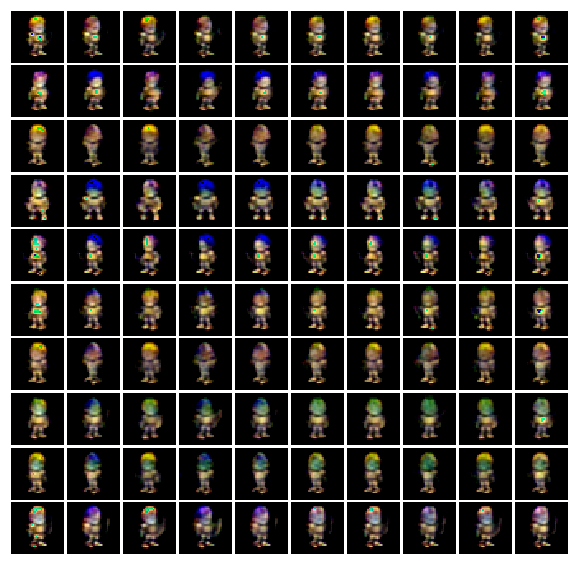

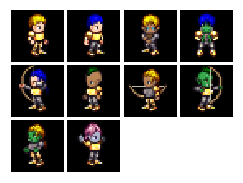

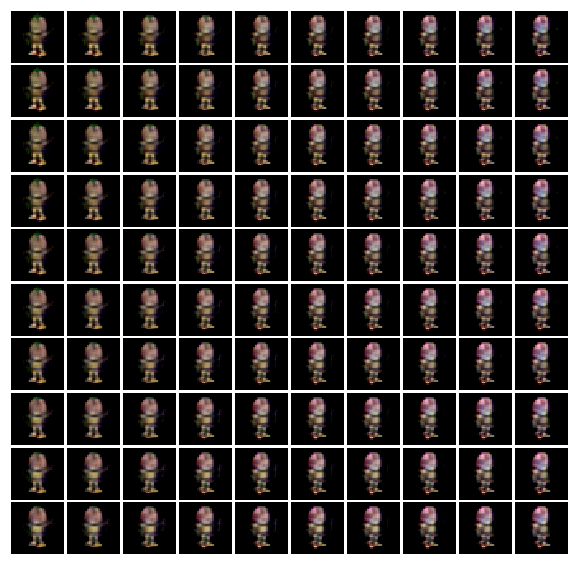

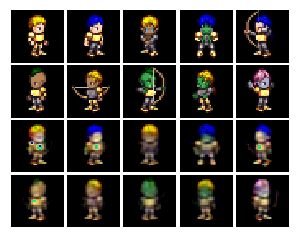


progress: 0.01, total iter: 9000, losses: recon:0.0105, disent:-2.9733, adv:5.9677 
z_latent_norm: tensor(51.5693, device='cuda:0')


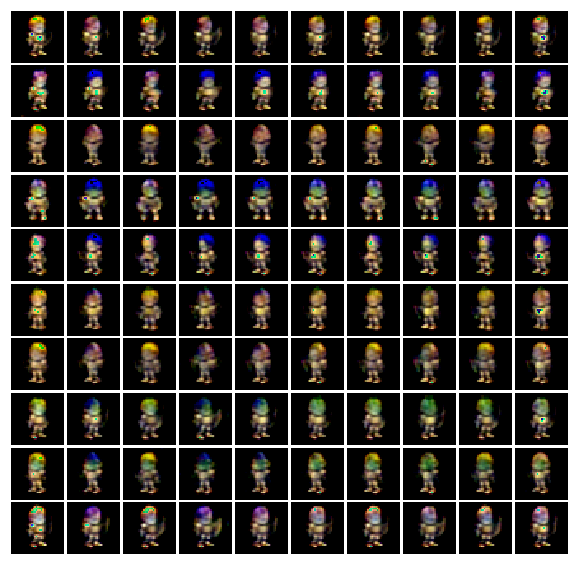

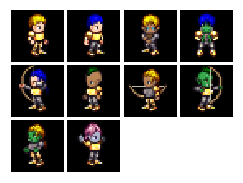

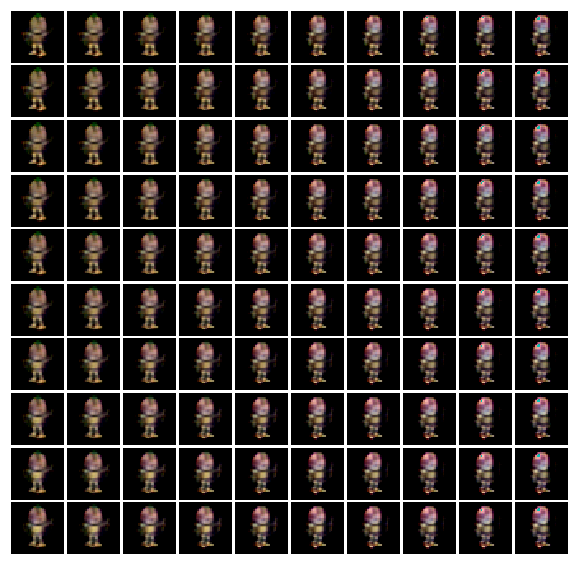

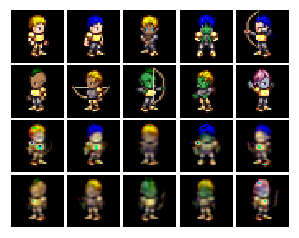

KeyboardInterrupt: 

In [132]:
solver.train(10000)

z_latent_norm: tensor(45.0877, device='cuda:0')


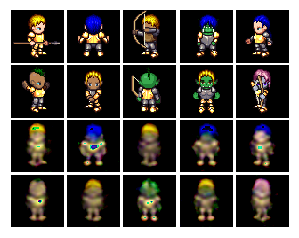

In [69]:
solver.params = SPRITESParameters()
solver.reconSolver.params = solver.params
solver.reconSolver.test()